In [2]:
# Training a RNN to predict ratings for anime based on existing ratings

import gc
import pandas as pd
import sqlite3

In [3]:
all_ratings = pd.read_csv('./work/data/animelists_cleaned.csv')

# only retain the "username", "anime_id", and "my_score" columns
ratings = all_ratings[['username', 'anime_id', 'my_score']]
# only retain rows where "my_score" is not null and greater than or equal to 6
ratings = ratings[ratings['my_score'].notnull()]
# ratings = ratings[ratings['my_score'] >= 6]

def scale_rating(rating: int) -> float:
    if rating == 10:
        return 10.1
    if rating == 9:
        return 9.1
    if rating == 8:
        return 6.5
    if rating == 7:
        return 3.3
    if rating == 6:
        return 1.2
    raise ValueError("Invalid rating: {}".format(rating))

# scale ratings from score to our custom scale
# ratings['my_score'] = ratings['my_score'].apply(scale_rating)

print("Remaining ratings:", ratings.shape[0])
print(ratings.head())

gc.collect()

Remaining ratings: 31284030
   username  anime_id  my_score
0  karthiga        21         9
1  karthiga        59         7
2  karthiga        74         7
3  karthiga       120         7
4  karthiga       178         7


0

In [4]:
# Load the ratings into a sqlite database
conn = sqlite3.connect('./work/data/ratings.db')
ratings.to_sql('ratings', conn, if_exists='replace', index=False)

# Index by username and anime_id
conn.execute("CREATE INDEX IF NOT EXISTS username_idx ON ratings (username)")
conn.execute("CREATE INDEX IF NOT EXISTS anime_id_idx ON ratings (anime_id)")

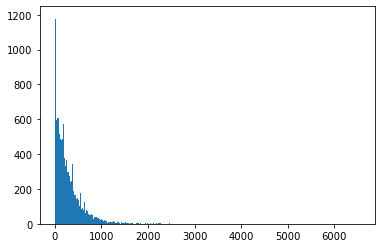

In [5]:
# plot distribution of # of ratings per user
import matplotlib.pyplot as plt

res = conn.execute("SELECT COUNT(*) FROM ratings GROUP BY username")
counts = [row[0] for row in res]
plt.hist(counts, bins=3000)
plt.show()

In [6]:
all_animes = pd.read_csv('./work/data/anime_cleaned.csv')
all_animes = all_animes[['anime_id', 'title']]

all_animes.to_sql('animes', conn, if_exists='replace', index=False)

6668

Nichijou ID: 10165
Nichijou ratings distribution: [(1, 42), (2, 36), (3, 70), (4, 147), (5, 403), (6, 749), (7, 2040), (8, 4012), (9, 4176), (10, 3444)]


<BarContainer object of 10 artists>

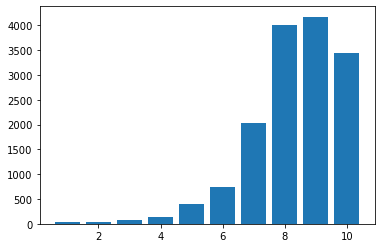

In [7]:
nichijou_id = conn.execute("SELECT anime_id FROM animes WHERE title = 'Nichijou'").fetchone()[0]
print("Nichijou ID:", nichijou_id)
nichijou_ratings_distribution = conn.execute("SELECT my_score, COUNT(*) FROM ratings WHERE anime_id = ? AND my_score > 0 GROUP BY my_score", (nichijou_id,)).fetchall()
print("Nichijou ratings distribution:", nichijou_ratings_distribution)
plt.bar([row[0] for row in nichijou_ratings_distribution], [row[1] for row in nichijou_ratings_distribution])


Kill Me Baby ID: 11079
Kill Me Baby ratings distribution: [(1, 41), (2, 95), (3, 146), (4, 283), (5, 517), (6, 917), (7, 1269), (8, 899), (9, 405), (10, 255)]


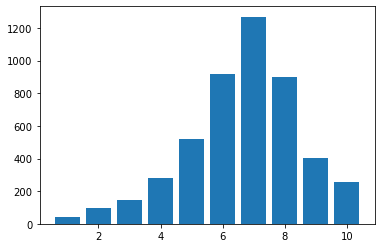

In [8]:
kill_me_baby_id = conn.execute("SELECT anime_id FROM animes WHERE title = 'Kill Me Baby'").fetchone()[0]
print("Kill Me Baby ID:", kill_me_baby_id)
kill_me_baby_ratings_distribution = conn.execute("SELECT my_score, COUNT(*) FROM ratings WHERE anime_id = ? AND my_score > 0 GROUP BY my_score", (kill_me_baby_id,)).fetchall()
print("Kill Me Baby ratings distribution:", kill_me_baby_ratings_distribution)
plt.bar([row[0] for row in kill_me_baby_ratings_distribution], [row[1] for row in kill_me_baby_ratings_distribution])
plt.show()

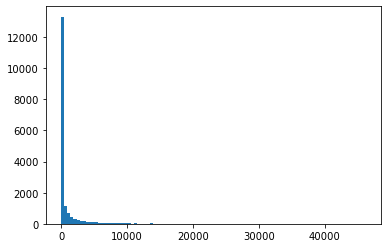

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

all_animes = pd.read_csv('./work/data/processed-metadata.csv')

# Plot distribution of # of ratings per anime
rating_count = all_animes['rating_count']
plt.hist(rating_count, bins=100)
plt.show()

In [36]:
import math

def get_extra_topn(rating_count):
    return int(max(math.pow(rating_count, 0.46) * 0.4 - 10, 0))

# get_extra_topn(5000)
len(all_animes[all_animes['rating_count'] > 5000])

877